# Project: **Finding Lane Lines on the Road** 

## Import Packages

In [16]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


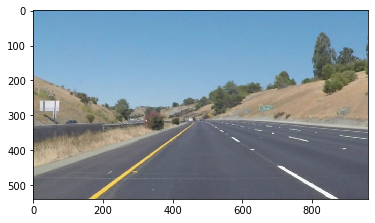

In [11]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve2.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  
#show a single color channel image: plt.imshow(gray, cmap='gray')

## Helper Functions

In [12]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def getLinePoint(lines):
    """
    `lines` should be the output of cv2.HoughLinesP()
    This function seperate left lane from right lane and average their slope and end points.
    Returns a dictionnary of current image's lane line status.
    """
    left_slopes = []
    left_points = [[],[]]
    avg_m_left = 0
    avg_x_left = 0
    avg_y_left = 0
    
    right_slopes = []
    right_points = [[],[]]
    avg_m_right = 0
    avg_x_right = 0
    avg_y_right = 0
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y1-y2)/(x1-x2)
            if -0.9 < slope < -0.5: 
                left_slopes.append(slope)
                left_points[0].append(x1)   #x1
                left_points[0].append(x2)     #x2
                left_points[1].append(y1)   #y1
                left_points[1].append(y2)     #y2
            #right line
            elif 0.9 > slope > 0.5:
                right_slopes.append(slope)
                cur_start, cur_end = [x1,y1],[x2,y2]
                cur_start, cur_end = [x2,y2],[x1,y1]
                right_points[0].append(x1)
                right_points[0].append(x2) 
                right_points[1].append(y1)
                right_points[1].append(y2)
            else:
                continue

    if len(left_slopes) != 0:
        avg_m_left = sum(left_slopes) / len(left_slopes)
        avg_x_left = int(sum(left_points[0])/len(left_points[0]))
        avg_y_left = int(sum(left_points[1])/len(left_points[1]))

    if len(right_slopes) != 0:
        avg_m_right = sum(right_slopes) / len(right_slopes)
        avg_x_right = int(sum(right_points[0])/len(right_points[0]))
        avg_y_right = int(sum(right_points[1])/len(right_points[1]))

    avg_p_left = (avg_x_left,avg_y_left)
    avg_p_right = (avg_x_right,avg_y_right)
    cur_status = {"avg_m_left":avg_m_left,"avg_m_right":avg_m_right,
                  "avg_p_left":avg_p_left,"avg_p_right":avg_p_right}
    return cur_status

## Global variables

In [13]:
prev_status = {}

## Building Lane Finding Pipeline



In [14]:
def draw_lane_lines(img):
    global prev_status
    # Change color to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #Apply Gaussian smoothing: remove noise that result in great gradient difference
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray_img,(kernel_size,kernel_size),0)
    #Apply Canny: create edge plot using gradient difference
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    #Apply mask: extract the region of interest
    half_height = img.shape[0] //2
    tuned_height = half_height + 45
    half_width = img.shape[1] //2

    left_top = (half_width - 10,tuned_height)
    left_bot = (130,img.shape[0])
    right_top = (half_width + 10,tuned_height)
    right_bot = (img.shape[1] - 80,img.shape[0])

    vertices = np.array([[left_bot,left_top,right_top,right_bot]], dtype=np.int32)
    masked = region_of_interest(edges,vertices)
    #Apply Hough transform: detecting lines
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    hough_threshold = 5   # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 3    # maximum gap in pixels between connectable line segments
    line_image = np.copy(img)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked, rho, theta, hough_threshold, np.array([]),
                                min_line_length, max_line_gap)
    # Iterate over lines and get average line
    cur_status = getLinePoint(lines)
    if cur_status["avg_m_left"] == 0 or cur_status["avg_m_right"] == 0:
        cur_status = prev_status
    else:
        prev_status = cur_status
    
    
    avg_m_left = cur_status["avg_m_left"]
    avg_m_right = cur_status["avg_m_right"]
    avg_p_left = cur_status["avg_p_left"]
    avg_p_right = cur_status["avg_p_right"]
    
    #define line ending height
    line_end_height = tuned_height + 50
    
    #draw left line
    left_start = (int(((img.shape[0] - avg_p_left[1])/avg_m_left) + avg_p_left[0]),img.shape[0])
    left_end = (int(((line_end_height - avg_p_left[1])/avg_m_left) + avg_p_left[0]),int(line_end_height))
    cv2.line(line_image,left_start,left_end,(255,0,0),10)
    
    #draw right line
    right_start = (int(((img.shape[0] - avg_p_right[1])/avg_m_right) + avg_p_right[0]),img.shape[0])
    right_end = (int(((line_end_height - avg_p_right[1])/avg_m_right) + avg_p_right[0]),int(line_end_height))
    cv2.line(line_image,right_start,right_end,(255,0,0),10)
    
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)
    return lines_edges

In [18]:
#Get results
draw_list = []
for image_name in os.listdir("test_images/"):
    path = 'test_images/' + image_name
    print(path)
    image = mpimg.imread(path)
    draw_list.append(draw_lane_lines(image))

test_images/solidYellowCurve.jpg
test_images/solidYellowLeft.jpg
test_images/solidYellowCurve2.jpg
test_images/solidWhiteRight.jpg
test_images/whiteCarLaneSwitch.jpg
test_images/solidWhiteCurve.jpg


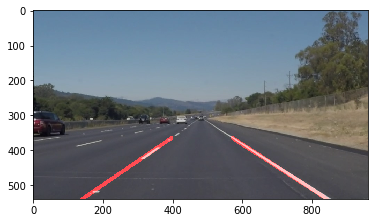

In [19]:
#Check result
plt.imshow(draw_list[3])

## Test on Videos

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
def process_image(image):
    result = draw_lane_lines(image)
    return result

In [22]:
%%capture
white_output = 'test_videos_output/solidWhiteRight.mp4'
##for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

The video can be found [here](https://youtu.be/y_bah3mGO3c)